# Network test on mnist dataset

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Data import

In [89]:
def bytes_to_pixels(image_bytes):
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
    pixel_values = image.flatten()
    return pixel_values

In [90]:
training_data_path = 'train.parquet'
test_data_path = 'test.parquet'

In [91]:
percentage_of_dataset = 1

In [92]:
df1 = pd.read_parquet(training_data_path)

df1['pixels'] = df1['image.bytes'].apply(bytes_to_pixels)

df2 = pd.read_parquet(test_data_path)

df2['pixels'] = df2['image.bytes'].apply(bytes_to_pixels)

df = pd.concat([df1[: int(len(df1) * percentage_of_dataset)], df2[: int(len(df2) * percentage_of_dataset)]], ignore_index=True)


print(df[['pixels', 'label']])

                                                  pixels  label
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      1
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      9
...                                                  ...    ...
69995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      2
69996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      3
69997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
69998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
69999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      6

[70000 rows x 2 columns]


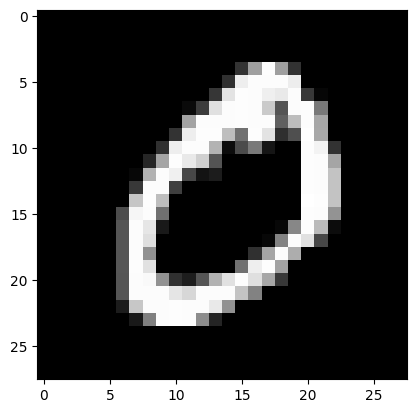

In [103]:
def draw_from_pixels(img):
    first_image_pixels = img
    image_shape = (28, 28)  

    image_array = np.array(first_image_pixels).reshape(image_shape)

    plt.imshow(image_array, cmap='gray')
    plt.show()

draw_from_pixels(df.loc[1, 'pixels'])

## Dataset initialisation

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder


X = df[['pixels', 'label']].copy()

y = (X.pop('label')).astype(int).values.reshape(-1, 1)

X = np.vstack(df['pixels'].values)

train_valid_size = 0.14

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)


label_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

X_train.shape, y_train.shape

C:\Users\andrz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((51771, 784), (51771, 10))

## Multilayer neural network

In [95]:
import sys
sys.path.append('../network') 
from network import Network

In [125]:
learning_rate = 1e-3
input_size = X_train.shape[1]
output_size = y_train.shape[1]

early_stopping_patience = 8

model = Network()

model.add_layer(input_size, 128, activation_function='relu', batch_norm_1d_size=64)
model.add_layer(128, 128, activation_function='relu', batch_norm_1d_size=64)
model.add_layer(128, output_size, activation_function='softmax')

model.early_stopping(early_stopping_patience=early_stopping_patience)

In [126]:
model.fit(X=X_train, y=y_train, learning_rate=learning_rate, epochs=200, verbose=1, batch_size=128)

Epoch 0: loss = 0.1293981837945329
Epoch 10: loss = 0.03890207315235349
Epoch 20: loss = 0.0345869306028546


In [127]:
from sklearn.metrics import  roc_auc_score

y_pred_test_score = model.predict(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)
print(f"AUROC: {100 * auroc:.2f}%")

AUROC: 90.45%


In [128]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, (28, 28))
    
    img_normalized = img_resized.astype('float32') / 255.0

    img_input = img_normalized.flatten().reshape(1, -1)
    
    return img_input

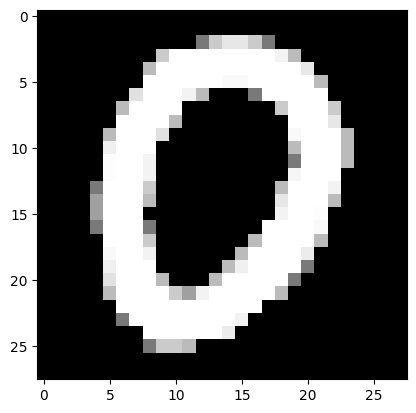

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [129]:
image_path = 'my_data/01.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(number_pred)

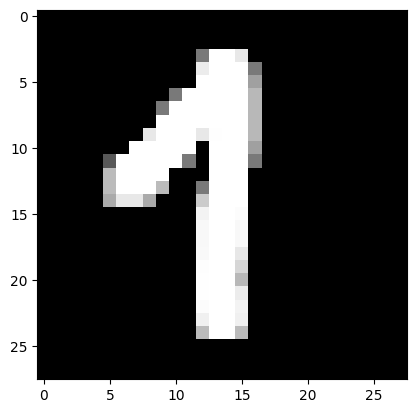

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [132]:
image_path = 'my_data/11.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(np.round(number_pred, decimals=0))

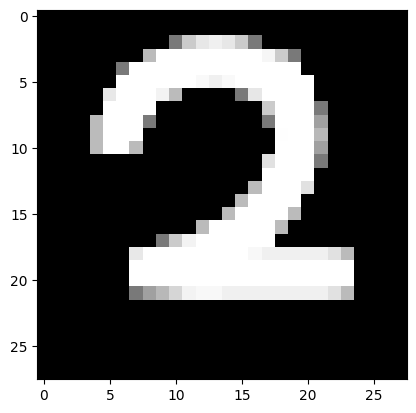

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [131]:
image_path = 'my_data/21.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(number_pred)